<a href="https://colab.research.google.com/github/trevmon28/CFBAnalytics/blob/main/LRMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import cfbd

configuration = cfbd.Configuration(
    access_token = 'cLT9Y7tfnPM255yFGufWO/envshda+OZ6TXiEIlQNfCDDAJgqzNsi9+dwqyjbeOY'
)

with cfbd.ApiClient(configuration) as api_client:
    api_instance = cfbd.GamesApi(api_client)
    games = api_instance.get_games(year=2025)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

In [38]:
seasons = [api_instance.get_games(year=iteryear, season_type='both') for iteryear in range(2015,2022)]
games = [game for season in seasons for game in season]

games_df = pd.DataFrame().from_records([
                dict(
                    id=g.id,
                    neutral_site=g.neutral_site,
                    home_team=g.home_team,
                    home_conference=g.home_conference,
                    home_points=g.home_points,
                    away_team=g.away_team,
                    away_conference=g.away_conference,
                    away_points=g.away_points,
                    season=g.season
                )
                for g in games
                if g.home_points is not None
                    and g.away_points is not None
                    and g.home_conference is not None
                    and g.away_conference is not None
            ])
games_df.head()

,id,neutral_site,home_team,home_conference,home_points,away_team,away_conference,away_points,season
0,400795501,False,Montana,Big Sky,38,North Dakota State,MVFC,35,2015
1,400603840,True,South Carolina,SEC,17,North Carolina,ACC,13,2015
2,400763593,False,UCF,American Athletic,14,Florida International,Conference USA,15,2015
3,400763399,False,Central Michigan,Mid-American,13,Oklahoma State,Big 12,24,2015
4,400756896,False,Wake Forest,ACC,41,Elon,CAA,3,2015


In [21]:
games_df.loc[(games_df['id'] == 401112476)]

,id,neutral_site,home_team,home_conference,home_points,away_team,away_conference,away_points,season
6761,401112476,False,Miami,ACC,35,Virginia Tech,ACC,42,2019


In [22]:
opponents = games_df['away_team'][((games_df['home_team'] == 'Virginia Tech') & (games_df['season'] == 2019))].tolist() + games_df['home_team'][((games_df['away_team'] == 'Virginia Tech') & (games_df['season'] == 2019))].tolist() + games_df['away_team'][((games_df['home_team'] == 'Miami') & (games_df['season'] == 2019))].tolist() + games_df['home_team'][((games_df['away_team'] == 'Miami') & (games_df['season'] == 2019))].tolist()

common_opponents = set([team for team in opponents if opponents.count(team) > 1])

common_opponents

{'Duke', 'Georgia Tech', 'North Carolina', 'Pittsburgh', 'Virginia'}

In [23]:
vt_w = 0
mia_w = 0
vt_g = 0
mia_g = 0
for index, game in games_df.loc[games_df['season'] == 2019].iterrows():
    if (game['home_team'] == 'Virginia Tech') & (game['away_team'] in common_opponents):
        vt_g += 1
        if game['home_points'] > game['away_points']:
            vt_w += 1
    elif (game['home_team'] == 'Miami') & (game['away_team'] in common_opponents):
        mia_g += 1
        if game['home_points'] > game['away_points']:
            mia_w += 1
    elif (game['away_team'] == 'Virginia Tech') & (game['home_team'] in common_opponents):
        vt_g += 1
        if game['away_points'] > game['home_points']:
            vt_w += 1
    elif (game['away_team'] == 'Miami') & (game['home_team'] in common_opponents):
        mia_g += 1
        if game['away_points'] > game['home_points']:
            mia_w += 1

print("Virginia Tech's common opponent WPCT: " + str(vt_w / vt_g))
print("Miami's common opponent WPCT: " + str(mia_w / mia_g))

Virginia Tech's common opponent WPCT: 0.6
Miami's common opponent WPCT: 0.4


In [25]:
train_games_df = games_df.loc[(games_df['season'].isin([2015,2016,2017,2018])) & (~games_df['neutral_site'])]

train_df = []

for index, game in train_games_df.iterrows():
    season = game['season']
    team_a = game['home_team']
    team_b = game['away_team']
    home_diff = game['home_points'] - game['away_points']
    opponents = games_df['away_team'][((games_df['home_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['away_team'][((games_df['home_team'] == team_b) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_b) & (games_df['season'] == season))].tolist()
    common_opponents = set([team for team in opponents if opponents.count(team) > 1])
    if len(common_opponents) > 1:
        a_w = 0
        b_w = 0
        a_g = 0
        b_g = 0
        for index, sub_game in games_df.loc[(games_df['season'] == season) &
                                        ((games_df['home_team'].isin([team_a,team_b])) |
                                          games_df['away_team'].isin([team_a,team_b]))].iterrows():
            if (sub_game['home_team'] == team_a) & (sub_game['away_team'] in common_opponents):
                a_g += 1
                if sub_game['home_points'] > sub_game['away_points']:
                    a_w += 1
            elif (sub_game['home_team'] == team_b) & (sub_game['away_team'] in common_opponents):
                b_g += 1
                if sub_game['home_points'] > sub_game['away_points']:
                    b_w += 1
            elif (sub_game['away_team'] == team_a) & (sub_game['home_team'] in common_opponents):
                a_g += 1
                if sub_game['away_points'] > sub_game['home_points']:
                    a_w += 1
            elif (sub_game['away_team'] == team_b) & (sub_game['home_team'] in common_opponents):
                b_g += 1
                if sub_game['away_points'] > sub_game['home_points']:
                    b_w += 1

        if a_g > 0 and b_g > 0: # Add this condition to prevent ZeroDivisionError
            r_x = ((a_w / a_g) + (1 - (b_w / b_g))) / 2

            d = {
                'season' : season,
                'team_a' : team_a,
                'team_b' : team_b,
                'home_diff' : home_diff,
                'r_x' : r_x,
                'weight' : a_g+b_g
            }
            train_df.append(d)

train_df = pd.DataFrame(train_df)
train_df.head()

,season,team_a,team_b,home_diff,r_x,weight
0,2015,Montana,North Dakota State,3,0.375000,10
1,2015,Western Illinois,Eastern Illinois,28,0.666667,5
2,2015,Northwestern State,SE Louisiana,-14,0.750000,12
3,2015,Utah,Michigan,7,0.500000,4
4,2015,Tulane,Duke,-30,0.250000,4


a = 0.02458789156130485
b = -0.08381094200619121


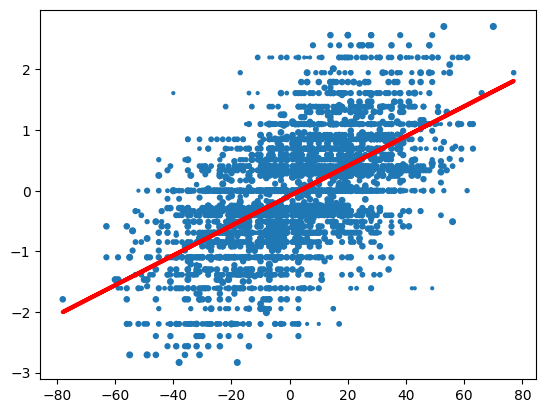

In [26]:
train_df.loc[train_df['r_x'] == 1,'r_x'] = 0.9
train_df.loc[train_df['r_x'] == 0,'r_x'] = 0.1

x = np.array(train_df['home_diff']).reshape(-1,1)
y = np.log(train_df['r_x'] / (1 - train_df['r_x']))
w = train_df['weight']
model = LinearRegression().fit(x, y, w)
plt.scatter(x, y, s = w)
plt.plot(x, model.predict(x), color='red', linewidth=3, label='Weighted model')
a = model.coef_[0]
b = model.intercept_
print("a = " + str(a))
print("b = " + str(b))

In [27]:
print(math.exp(a * -7 + b) / (1 + math.exp(a * -7 + b)))

0.4363654050435186


In [28]:
h = (-b / a)
print(h)

3.4086266322277314


In [29]:
games_df_2019 = games_df.loc[games_df['season'] == 2019]
games_df_2019.head()

,id,neutral_site,home_team,home_conference,home_points,away_team,away_conference,away_points,season
6144,401128622,False,Colgate,Patriot,14,Villanova,CAA,34,2019
6145,401127303,True,Samford,Southern,22,Youngstown State,MVFC,45,2019
6146,401110723,True,Florida,SEC,24,Miami,ACC,20,2019
6147,401114164,False,Hawai'i,Mountain West,45,Arizona,Pac-12,38,2019
6148,401117854,False,Cincinnati,American Athletic,24,UCLA,Pac-12,14,2019


In [31]:
for index, game in games_df_2019.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    home_points = game['home_points']
    away_points = game['away_points']
    neutral_flg = game['neutral_site']
    home_team_ndx = team_names.index(home_team)
    away_team_ndx = team_names.index(away_team)
    spread = home_points - away_points
    if neutral_flg:
        spread += h
    r_x = math.exp(a * spread + b) / (1 + math.exp(a * spread + b))
    n_games[home_team_ndx] += 1
    n_games[away_team_ndx] += 1
    p[home_team_ndx, away_team_ndx] += 1 - r_x
    p[away_team_ndx, home_team_ndx] += r_x
    p[home_team_ndx, home_team_ndx] += r_x
    p[away_team_ndx, away_team_ndx] += 1 - r_x

In [32]:
p = p / n_games[:,None]
print(p)

[[0.47038829 0.         0.         ... 0.         0.         0.        ]
 [0.         0.58448954 0.         ... 0.03348158 0.         0.        ]
 [0.         0.         0.35111637 ... 0.         0.         0.        ]
 ...
 [0.         0.04344149 0.         ... 0.54543484 0.         0.        ]
 [0.         0.         0.         ... 0.         0.56963704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.51692369]]


In [33]:
prior = n_teams - np.array(list(range(n_teams)))
steady_state = np.linalg.matrix_power(p, 1000)
rating = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'team': team_names,
    'lrmc_rating': rating

})
print(rating_df.sort_values(by=['lrmc_rating'], ascending=False).iloc[0:25])

                   team  lrmc_rating
180          Ohio State   644.261182
109                 LSU   632.795228
41              Clemson   575.181505
3               Alabama   472.027345
292           Wisconsin   442.902877
78              Georgia   426.574776
186              Oregon   423.853129
181            Oklahoma   404.656773
188          Penn State   395.391207
14               Auburn   394.142930
66              Florida   386.035826
264                Utah   377.280247
18               Baylor   370.072774
178          Notre Dame   362.554867
134            Michigan   360.463442
237               Texas   337.519573
97                 Iowa   337.298510
129             Memphis   334.077784
277          Washington   324.934003
138           Minnesota   321.549439
169  North Dakota State   315.627236
253                 UCF   314.620002
98           Iowa State   308.660393
7             App State   307.744809
238           Texas A&M   307.200842


In [35]:
train_games_df = games_df.loc[(games_df['season'].isin([2016,2017,2018,2019])) & (~games_df['neutral_site'])]

train_df = []

for index, game in train_games_df.iterrows():
    season = game['season']
    team_a = game['home_team']
    team_b = game['away_team']
    home_diff = game['home_points'] - game['away_points']
    opponents = train_games_df['away_team'][((games_df['home_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['away_team'][((games_df['home_team'] == team_b) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_b) & (games_df['season'] == season))].tolist()
    common_opponents = set([team for team in opponents if opponents.count(team) > 1])
    if len(common_opponents) > 1:
        a_w = 0
        b_w = 0
        a_g = 0
        b_g = 0
        for index, game in games_df.loc[(games_df['season'] == season) &
                                        ((games_df['home_team'].isin([team_a,team_b])) |
                                          games_df['away_team'].isin([team_a,team_b]))].iterrows():
            if (game['home_team'] == team_a) & (game['away_team'] in common_opponents):
                a_g += 1
                if game['home_points'] > game['away_points']:
                    a_w += 1
            elif (game['home_team'] == team_b) & (game['away_team'] in common_opponents):
                b_g += 1
                if game['home_points'] > game['away_points']:
                    b_w += 1
            elif (game['away_team'] == team_a) & (game['home_team'] in common_opponents):
                a_g += 1
                if game['away_points'] > game['home_points']:
                    a_w += 1
            elif (game['away_team'] == team_b) & (game['home_team'] in common_opponents):
                b_g += 1
                if game['away_points'] > game['home_points']:
                    b_w += 1

        if a_g > 0 and b_g > 0: # Added condition to prevent ZeroDivisionError
            r_x = ((a_w / a_g) + (1 - (b_w / b_g))) / 2

            d = {
                'season' : season,
                'team_a' : team_a,
                'team_b' : team_b,
                'home_diff' : home_diff,
                'r_x' : r_x,
                'weight' : a_g+b_g
            }
            train_df.append(d)

train_df = pd.DataFrame(train_df)
train_df.loc[train_df['r_x'] == 1,'r_x'] = 0.9
train_df.loc[train_df['r_x'] == 0,'r_x'] = 0.1

x = np.array(train_df['home_diff']).reshape(-1,1)
y = np.log(train_df['r_x'] / (1 - train_df['r_x']))
w = train_df['weight']
model = LinearRegression().fit(x, y, w)
a = model.coef_[0]
b = model.intercept_
h = (-b / a) - 2

games_df_2020 = games_df.loc[games_df['season'] == 2020]
games_df_2020.head()

team_names = sorted(list(set(games_df_2020['home_team'].tolist() + games_df_2020['away_team'].tolist())))
n_teams = len(team_names)
p = np.zeros((n_teams,n_teams))
n_games = np.zeros(n_teams)

for index, game in games_df_2020.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    home_points = game['home_points']
    away_points = game['away_points']
    neutral_flg = game['neutral_site']
    home_team_ndx = team_names.index(home_team)
    away_team_ndx = team_names.index(away_team)
    spread = home_points - away_points
    if neutral_flg:
        spread += h
    r_x = math.exp(a * spread + b) / (1 + math.exp(a * spread + b))
    n_games[home_team_ndx] += 1
    n_games[away_team_ndx] += 1
    p[home_team_ndx, away_team_ndx] += 1 - r_x
    p[away_team_ndx, home_team_ndx] += r_x
    p[home_team_ndx, home_team_ndx] += r_x
    p[away_team_ndx, away_team_ndx] += 1 - r_x

p = p / n_games[:,None]
prior = n_teams - np.array(list(range(n_teams)))
steady_state = np.linalg.matrix_power(p, 1000)
rating = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'team': team_names,
    'lrmc_rating': rating

})
print(rating_df.sort_values(by=['lrmc_rating'], ascending=False).iloc[0:25])

                 team  lrmc_rating
4             Alabama  1065.804622
66            Clemson   701.125223
257          Oklahoma   691.358685
29                BYU   662.600753
149        Iowa State   640.324721
101           Florida   603.181909
250        Notre Dame   585.406614
42    Brevard College   557.267688
67   Coastal Carolina   551.752939
115           Georgia   535.152988
329             Texas   523.199689
258    Oklahoma State   513.021882
237    North Carolina   504.788917
330         Texas A&M   500.546146
255        Ohio State   499.999786
218           Montana   495.001467
65         Cincinnati   490.455739
15          App State   468.936116
176         Louisiana   467.137160
22             Auburn   458.675632
199             Miami   446.232160
7              Albion   441.879692
323               TCU   440.788054
247      Northwestern   437.213169
148              Iowa   424.024756


In [39]:
train_games_df = games_df.loc[(games_df['season'].isin([2016,2017,2018,2019])) & (~games_df['neutral_site'])]

train_df = []

for index, game in train_games_df.iterrows():
    season = game['season']
    team_a = game['home_team']
    team_b = game['away_team']
    home_diff = game['home_points'] - game['away_points']
    opponents = train_games_df['away_team'][((games_df['home_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_a) & (games_df['season'] == season))].tolist() + games_df['away_team'][((games_df['home_team'] == team_b) & (games_df['season'] == season))].tolist() + games_df['home_team'][((games_df['away_team'] == team_b) & (games_df['season'] == season))].tolist()
    common_opponents = set([team for team in opponents if opponents.count(team) > 1])
    if len(common_opponents) > 1:
        a_w = 0
        b_w = 0
        a_g = 0
        b_g = 0
        for index, game in games_df.loc[(games_df['season'] == season) &
                                        ((games_df['home_team'].isin([team_a,team_b])) |
                                          games_df['away_team'].isin([team_a,team_b]))].iterrows():
            if (game['home_team'] == team_a) & (game['away_team'] in common_opponents):
                a_g += 1
                if game['home_points'] > game['away_points']:
                    a_w += 1
            elif (game['home_team'] == team_b) & (game['away_team'] in common_opponents):
                b_g += 1
                if game['home_points'] > game['away_points']:
                    b_w += 1
            elif (game['away_team'] == team_a) & (game['home_team'] in common_opponents):
                a_g += 1
                if game['away_points'] > game['home_points']:
                    a_w += 1
            elif (game['away_team'] == team_b) & (game['home_team'] in common_opponents):
                b_g += 1
                if game['away_points'] > game['home_points']:
                    b_w += 1

        if a_g > 0 and b_g > 0: # Added condition to prevent ZeroDivisionError
            r_x = ((a_w / a_g) + (1 - (b_w / b_g))) / 2

            d = {
                'season' : season,
                'team_a' : team_a,
                'team_b' : team_b,
                'home_diff' : home_diff,
                'r_x' : r_x,
                'weight' : a_g+b_g
            }
            train_df.append(d)

train_df = pd.DataFrame(train_df)
train_df.loc[train_df['r_x'] == 1,'r_x'] = 0.9
train_df.loc[train_df['r_x'] == 0,'r_x'] = 0.1

x = np.array(train_df['home_diff']).reshape(-1,1)
y = np.log(train_df['r_x'] / (1 - train_df['r_x']))
w = train_df['weight']
model = LinearRegression().fit(x, y, w)
a = model.coef_[0]
b = model.intercept_
h = (-b / a) - 2

games_df_2021 = games_df.loc[games_df['season'] == 2021]
games_df_2021.head()

team_names = sorted(list(set(games_df_2021['home_team'].tolist() + games_df_2021['away_team'].tolist())))
n_teams = len(team_names)
p = np.zeros((n_teams,n_teams))
n_games = np.zeros(n_teams)

for index, game in games_df_2021.iterrows():
    home_team = game['home_team']
    away_team = game['away_team']
    home_points = game['home_points']
    away_points = game['away_points']
    neutral_flg = game['neutral_site']
    home_team_ndx = team_names.index(home_team)
    away_team_ndx = team_names.index(away_team)
    spread = home_points - away_points
    if neutral_flg:
        spread += h
    r_x = math.exp(a * spread + b) / (1 + math.exp(a * spread + b))
    n_games[home_team_ndx] += 1
    n_games[away_team_ndx] += 1
    p[home_team_ndx, away_team_ndx] += 1 - r_x
    p[away_team_ndx, home_team_ndx] += r_x
    p[home_team_ndx, home_team_ndx] += r_x
    p[away_team_ndx, away_team_ndx] += 1 - r_x

p = p / n_games[:,None]
prior = n_teams - np.array(list(range(n_teams)))
steady_state = np.linalg.matrix_power(p, 1000)
rating = prior.dot(steady_state)
rating_df = pd.DataFrame({
    'team': team_names,
    'lrmc_rating': rating

})
print(rating_df.sort_values(by=['lrmc_rating'], ascending=False).iloc[0:25])

                   team  lrmc_rating
126             Georgia   991.969020
4               Alabama   819.642447
201            Michigan   716.691710
266          Ohio State   704.281558
269      Oklahoma State   639.362815
65           Cincinnati   624.634235
379                Utah   613.498228
29               Baylor   601.995423
262          Notre Dame   577.486146
280          Pittsburgh   574.747078
247  North Dakota State   574.485213
267            Oklahoma   542.015915
154          Iowa State   541.332940
68              Clemson   529.018833
392         Wake Forest   526.777536
423           Wisconsin   522.354988
276          Penn State   521.594561
271            Ole Miss   515.326002
412    Western Kentucky   507.551583
202      Michigan State   505.600183
153                Iowa   500.387065
316  South Dakota State   500.296640
16             Arkansas   497.317754
272              Oregon   496.691720
141             Houston   496.671068
